In [ ]:
#git clone before notebook

---

<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Oracle_logo.svg/2560px-Oracle_logo.svg.png" width="200" align = "left"></p>

## **<h1 align ="middle"><b>Lab 4 - OCI Data Science</b></h1>**
### **<h1 align ="middle"><b>    OCI Document Understanding</b></h1>**
### **<h1 align ="middle"><b> Classification and Key Value Extractions</b></h1>**
##### **<h1 align ="middle"><b> Merging 3 models in one endpoint</b></h1>**

---

## **Overview steps in Lab 4**

<details>
<summary><font size="4">Step 1 - Create Conda Environment </font></summary>

```md
   In this step, you will select and create a conda environment. The conda environment is then used to run this notebook. In the steps, you will open a new terminal, use the odsc conda install command to install the generalml_p38_cpu_v1 conda environment.
```
</details>

<details>
<summary><font size="4">Step 2 - Add your OCI Document Understanding variables</font></summary>

```md
   In previous steps, you created 3 different custom models in OCI Document Understanding. In this step, you will add the 3 different Model OCIDS. In addition, you will add and define other needed variables. These are your compartment OCID, bucket name, namespace, and prefix.
```
</details>

<details>
<summary><font size="4">Step 3 - Upload a Walgreen and Wholefoods example</font></summary>

```md
   In this step, you will upload two PDF file in the directory on the left. Please only use the 'wholefoods_1.pdf' and 'walgreens_1.pdf' files.
```
</details>

<details>
<summary><font size="4">Step 4 - Upload Config file and Private Key</font></summary>

```md
   In Lab 1, you created a config file and private key. In this step, you will upload both files in the directory on the left. Please upload both files into the 'model_artifacts' folder.
```
</details>

<details>
<summary><font size="4">Step 5 - Run Notebook - Invoke Classification and Key Value Extraction in one flow</font></summary>

```md
   In this step, you will run this notebook step by step. You can run the notebook by clicking on the play button or by performing Shift+enter or Ctrl+enter when you select the cell you want to run.
```
</details>


----

## **Step 1 - Create Conda Environment**

---

### **1.1 Open a Terminal**

- 1. Click on the **"Launcher"** tab. If not visible, click on the **"+"** button on the left.
- 2. Click on **"Terminal"**. This will open a terminal.

----

### **1.2 Install a pre-defined Conda**

#### In the terminal, copy, paste and run the below command. This will install the Computer Vision for GPU on Python 3.7 Conda environment

In [ ]:
odsc conda install -s generalml_p38_cpu_v1

---

### **1.3 Select and use the computervision_p37_gpu_v1 Cona**

- 1. Please wait untill the Conda environment is installed in the previous step.
- 2. In this notebook, in the top-right corner, select the **'generalml_p38_cpu_v1'** as your Kernel. Click on **'Select'** after selecting the correct kernel.

---

## **Step 2 - Add your OCI Document Understanding variables**

#### In the below cell, between the empty brackets, add the following variables:
- Model OCID for the custom classification model
- Model OCID for the custom key value extraction model for Wholefoods
- Model OCID for the custom key value extraction model for Walgreens
- Your bucket name
- Your namespace
- Your compartment OCID
- (Optional) Add or change the prefix

Run the cell (Play button or Shift-Enter) when done

In [12]:
## Add the Model OCID of your custom Receipt classification model
model_1_classification = "ocid1.aidocumentmodel.oc1.eu-frankfurt-1.amaaaaaangencdyaoawxvuk7cubv5nf7shwgwqp3qbvggxiob7ljpxrci22a"

## Add the Model OCID of your custom key value extractions for Wholefoods
model_2_wholefoods_kv = "ocid1.aidocumentmodel.oc1.eu-frankfurt-1.amaaaaaangencdyaryeppopftukryka7bym4uviyynfzbpc6dfszyrpch56a"

## Add the Model OCID of your custom key value extractions for Walgreens
model_3_walgreens_kv = "ocid1.aidocumentmodel.oc1.eu-frankfurt-1.amaaaaaangencdyajn367pu5cqpf64g3uunvqw7eewtb67esmacsgbz7jfqa"

## Add here you Bucket Name
bucket_name = "West_BP"

## Add here you Namespace
namespace = "frqap2zhtzbe"

## Add here you Compartment OCID
compartment_ocid = "ocid1.compartment.oc1..aaaaaaaae3n6r6hrjipbap2hojicrsvkzatrtlwvsyrpyjd7wjnw4za3m75q"

## Add here or leave as is the prefix for all OCI Document Understanding output files
output_name_prefix = "Receipts_output"

---

## **Step 3 - Upload Config file and Private Key**

- 1. In Lab 1, you generated a **'config'** and a **'private_key.pem'** file.
- 2. Upload your **'config'** file and your **'private_key.pem'** file. You can **'drag & drop'** both files in the directory on the left
- 3. In the config file, make sure the last line is **'key_file=./private_key.pem'**

----

## **Step 4 - Run Notebook - Invoke Classification and Key Value Extraction in one flow**

### **4.1 Import libraries**

#### Run the below cell

In [13]:
import os
os.system('pip install opencv-python-headless torch')
os.system('pip install oci --upgrade')
import oci
import cv2
import uuid
import json
import base64
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

---

### **4.2 Create a payload. Run the below cell and choose between 'wholefoods' or 'walgreens'**

#### Run the below cell. Add either "wholefoods" or "walgreens" without the brackets in the cell and hit enter

In [14]:
input_brand = input()

 wholefoods


#### Run the below cell. This will convert either the 'wholefoods_1.pdf' or 'walgreen_1.pdf' into Base64 format

In [15]:
document = f"./{input_brand}_1.pdf"
document_no_ext = document[:-4]

with open(document, "rb") as document_file:
    receipt_encoded = base64.b64encode(document_file.read()).decode('utf-8')
    
#create full json input for model
full_json_input = {'data':receipt_encoded}

---

### **4.3 Define Full Flow**

#### Run the below cell. The full Python script integrates the 3 different models in one flow. The flow is:
- 1. The encoded PDF file (as Base64) is received
- 2. The encoded PDF file is sent to Model 1 - The custom classification model. The model clasifies the receipt as 'wholefoods' or 'walgreens'
- 3. Based on the output of model 1, the encoded PDF file is sent to Model 2 (Wholefoods) or Model 3 (Walgreens) for Key Value Extraction
- 4. The results of the Key Value Extraction are returned

In [55]:
##################################################################################
################################################################################## Imports
##################################################################################

from PIL import Image
import torch
import numpy as np
import pandas as pd
import os
import io
import shutil
import sys
import glob
import ads
import urllib
import base64
import uuid
import json
import oci

##################################################################################
################################################################################## Config file
##################################################################################

config = oci.config.from_file("./config", 'DEFAULT')  #in the notebook

##################################################################################
################################################################################## Load a Dummy model, used when storing and deploying the model
##################################################################################

def load_model():
    class DummyModel:
        def __init__(self):
            pass
    return DummyModel()

##################################################################################
################################################################################## OCI Document Understanding, Functions and APIs
##################################################################################

def receipt_classification(config, receipt_encoded):

    aiservicedocument_client = oci.ai_document.AIServiceDocumentClient(config=config)
    
    # Start Document Classification, using custom model OCID
    key_value_extraction_feature = oci.ai_document.models.DocumentClassificationFeature(model_id = model_1_classification)
    
    # input receipt and output location
    input_loc = oci.ai_document.models.InlineDocumentContent(data=receipt_encoded)
    output_location = oci.ai_document.models.OutputLocation()
    output_location.namespace_name = namespace
    output_location.bucket_name = bucket_name
    output_location.prefix = output_name_prefix

    # Define the Features
    processor_config = oci.ai_document.models.GeneralProcessorConfig(features=[key_value_extraction_feature])
    
    # Start Key value extraction
    kv_job_details = oci.ai_document.models.CreateProcessorJobDetails(
                        display_name=str(uuid.uuid4()),
                        compartment_id=compartment_ocid,
                        input_location=input_loc,
                        output_location=output_location,
                        processor_config=processor_config)

    processor_response = aiservicedocument_client.create_processor_job(create_processor_job_details=kv_job_details)
    
    return processor_response, output_location



def kv_extraction(config, receipt_encoded, selected_model_ocid):
    
    aiservicedocument_client = oci.ai_document.AIServiceDocumentClient(config=config)
    key_value_extraction_feature = oci.ai_document.models.DocumentKeyValueExtractionFeature(model_id=selected_model_ocid)
    input_loc = oci.ai_document.models.InlineDocumentContent(data=receipt_encoded)
    output_location = oci.ai_document.models.OutputLocation()
    output_location.namespace_name = namespace
    output_location.bucket_name = bucket_name
    output_location.prefix = output_name_prefix
    processor_config = oci.ai_document.models.GeneralProcessorConfig(features=[key_value_extraction_feature])
    kv_job_details = oci.ai_document.models.CreateProcessorJobDetails(
                        display_name=str(uuid.uuid4()),
                        compartment_id=compartment_ocid,
                        input_location=input_loc,
                        output_location=output_location,
                        processor_config=processor_config)

    processor_response = aiservicedocument_client.create_processor_job(create_processor_job_details=kv_job_details)
    output_location_kv = output_location
    processor_response_kv = processor_response
    
    return processor_response_kv, output_location_kv

    

def retrieve_results(config, processor_response, output_location):
    
    processor_job_id = processor_response.data.id
    object_storage_client = oci.object_storage.ObjectStorageClient(config=config)
    object_response = object_storage_client.get_object(namespace_name=output_location.namespace_name,
                                                           bucket_name=output_location.bucket_name,
                                                           object_name="{}/{}/_/results/defaultObject.json".format(
                                                               output_location.prefix, processor_job_id))
    
    result = str(object_response.data.content.decode())
    result_dict = json.loads(result)
    
    return result_dict



def predict(data, model=load_model()):
    
    #Get the Base64 pdf file
    document_encoded = data['data']
    
    
    ###################################################################################################################
    #### Model 1 - Classification of the receipt
    ###################################################################################################################
    
    print("--"*100)
    print("**Start model 1 - Receipt Classification**")
    print("--"*100)
    
    # Receipt classification functions
    processor_response, output_location = receipt_classification(config, receipt_encoded)
    
    # Retrieve Results from Object Storage
    result_dict = retrieve_results(config, processor_response, output_location)
    
    #define top category
    top_category = result_dict['pages'][0]['detectedDocumentTypes'][0]['documentType']
    
    print("--"*50)
    print("Detected type of documents")
    print(result_dict['pages'][0]['detectedDocumentTypes'])
    print("--"*50)
    print("Selected document type is ")
    print(top_category)
    print("--"*50)
    
    #define which key value extraction model to use    
    mapping = {"wholefoods":model_2_wholefoods_kv, 'walgreens':model_3_walgreens_kv}
    print("This is the mapping used between top category and key value extraction model chosen:")
    print(mapping)
    
    #select the correct Model OCID from the mapping
    selected_model_ocid = mapping[top_category]
    
    print("--"*50)
    print("Model OCID and top category used in key value extraction are ")
    print(top_category)
    print(selected_model_ocid)
    print("--"*50)
   
    ###################################################################################################################
    #### Key value extraction - Model 2 or Model 3
    ###################################################################################################################
    
    print("--"*100)
    print(f"**Start model 2 or model 3 - Key value extraction for {top_category}**")
    print("--"*100)
    
    #use key value extraction function and fetch results from bucket
    processor_response_kv, output_location_kv = kv_extraction(config, receipt_encoded, selected_model_ocid)
    result_dict_kv = retrieve_results(config, processor_response_kv, output_location_kv)
        
    ###################################################################################################################
    #### Final response
    ###################################################################################################################
    
    print("Process completed")
    pages_completed = result_dict_kv['documentMetadata']['pageCount']
    print(f"Number of pages in PDF analyzed: {pages_completed}")
    
    return result_dict_kv, top_category


----

### **4.4 Run the Full Flow**

#### Run the below cell. This will start the full flow with the encoded PDF file as input

Note. You can change the input PDF file by running step 5.2 again and choose a different brand

In [56]:
result_dict_kv, top_category = predict(full_json_input)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
**Start model 1 - Receipt Classification**
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Detected type of documents
[{'documentType': 'wholefoods', 'confidence': 0.5378965}, {'documentType': 'walgreens', 'confidence': 0.46210352}]
----------------------------------------------------------------------------------------------------
Selected document type is 
wholefoods
----------------------------------------------------------------------------------------------------
This is the mapping used between top category and key value extraction m

---

### **4.5 Visualize the results in the PDF and in a Table**

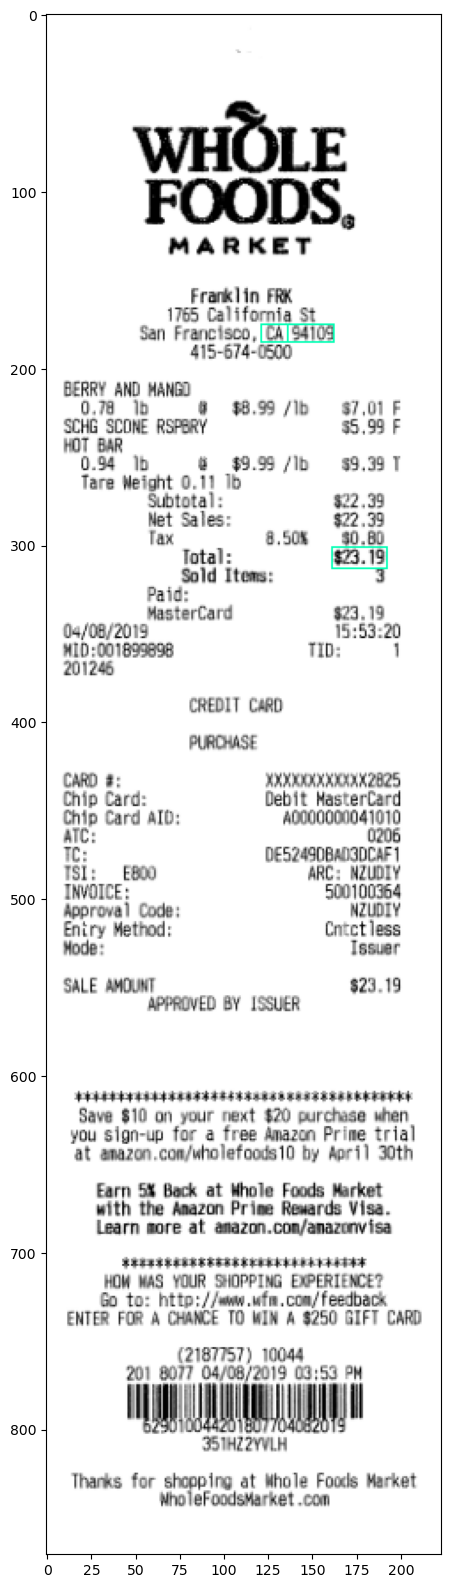

,page,label,value,confidence,receipt
0,1,postal_code_letters,CA,81.50,wholefoods
1,1,postal_code_numbers,94109,90.88,wholefoods
2,1,total_amount,$23.19,87.57,wholefoods


In [57]:
os.system('pip install PyMuPDF')
import fitz

def parse_results_visualise(result_dict, document, document_no_ext, top_category):

    # Open PDF Document 
    pages = fitz.open(document)

    # Iterate through the Pages
    for page in pages:  
        pix = page.get_pixmap()
        pix.save(f"{document_no_ext}-image-{page.number + 1}.png")
        
    # Create Empty DataFrame
    results_df = pd.DataFrame([], columns = ["page", "label", "value", "confidence", "receipt"])

    # Iterate over Pages
    for page in result_dict['pages']:

        # get original image
        im = cv2.imread(f"{document_no_ext}-image-{page['pageNumber']}.png")

        # dimension of image
        height, width, channels = im.shape

        # Iterate over Key Value Pairs and Respective Bounding Boxes
        for kv_pair in page['documentFields']:

            # get values
            name = kv_pair['fieldLabel']['name']
            value = kv_pair['fieldValue']['value']
            confidence = round(kv_pair['fieldLabel']['confidence']*100, 2)

            # key values
            results_list = [page['pageNumber'], name, value, confidence, top_category]
            a_series = pd.Series(results_list, index = results_df.columns)
            results_df = results_df._append(a_series, ignore_index=True)
            
            #bounding boxes
            bounding_polygon_x1 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][0]['x']*width)
            bounding_polygon_y1 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][0]['y']*height)
            bounding_polygon_x2 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][2]['x']*width)
            bounding_polygon_y2 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][2]['y']*height)
            coordinates_pt1 = (bounding_polygon_x1, bounding_polygon_y1)
            coordinates_pt2 = (bounding_polygon_x2, bounding_polygon_y2)
            cv2.rectangle(im, coordinates_pt1, coordinates_pt2, (180, 255, 0), 1)
            
            cv2.imwrite(f"{document_no_ext}-result-{page['pageNumber']}.png",im)
            
    for page in result_dict['pages']:

        fig = plt.figure()
        fig.set_size_inches(12, 20)

        # show image
        img = mpimg.imread(f"{document_no_ext}-result-{page['pageNumber']}.png")
        imgplot = plt.imshow(img)
        plt.show(imgplot)

    return results_df

# show table
results_df = parse_results_visualise(result_dict_kv, document, document_no_ext, top_category)
results_df.head(10)

----